# Rendering in frequency space using `phasor_hdr_film`

## Overview

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>
  
  Compute the frequency components of the time-resolved render of the Cornell Box scene using `phasor_hdr_film`</li>
  <li>
  
  Understand the output and visualize the frequency components</li>
</ul>

</div>

### What is rendering in frequency space?

In time-domain rendering you measure the temporal response of a light pulse. This gives a signal s(t) over time. Rendering in frequency space means directly computing specific frequency components of that signal, that is, for some frequencies $\Omega$ you measure
$$
S(\Omega) = \mathcal{F}\left\{s(t)\right\}
$$
where $\mathcal{F}$ represents the Fourier transform. In short, the `phasor_hdr_film` is very similar to `transient_hdr_film` but computes the Fourier transform of the measured values on the go. Later you will see how to choose the frequencies $\Omega$ that you measure (similar to `bin_width_opl`, `start_opl`, etc. configure what values of time you measure).

<div class="admonition important alert alert-block alert-warning">

This tutorial assumes that you've read `0-render_cbox_diffuse.ipynb`. Most of the setup code (importing `mitransient`, loading the scene, etc.) is the same. Here you get to see cool visualizations though :)

</div>

In [1]:
# If you have compiled Mitsuba 3 yourself, you will need to specify the path
# to the compilation folder
# import sys
# sys.path.insert(0, '<mitsuba-path>/mitsuba3/build/python')
import mitsuba as mi
# To set a variant, you need to have set it in the mitsuba.conf file
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
mi.set_variant('llvm_ad_mono')

import mitransient as mitr

print('Using mitsuba version:', mi.__version__)
print('Using mitransient version:', mitr.__version__)

Using mitsuba version: 3.6.4
Using mitransient version: 1.2.0


We use the short alias `mitr` for `mitransient` for improved code readibility.

### Setup the Cornell Box scene with `phasor_hdr_film`

See other tutorials for more information on how to load scenes using XML files. In this case, we have modified the scene's XML file with

```xml
<film type="phasor_hdr_film">
    <integer name="width"  value="$res"/>
    <integer name="height" value="$res"/>
    <float name="wl_mean" value="100"/>
    <float name="wl_sigma" value="100"/>
    <integer name="temporal_bins" value="4000"/>
    <float name="bin_width_opl" value="1"/>
    <float name="start_opl" value="0"/>
    <rfilter type="box">
        <!-- <float name="stddev" value="1.0"/> -->
    </rfilter>
</film>
```

The key values here are `wl_mean` and `wl_sigma`. These values are inspired by the Morlet wavelet filter used in phasor-field-based non-line-of-sight imaging. In practice, `wl_mean` controls the central frequency that is measured and `wl_sigma` is inversely proportional to the bandwidth. The values of $\Omega$ are aligned with the frequency values typical of the discrete Fourier transform corresponding to the `bin_width_opl` and `temporal_bins`.

In [2]:
# Load XML file
# You can also use mi.load_dict and pass a Python dict object
# but it is probably much easier for your work to use XML files
import os
scene = mi.load_file(os.path.abspath('cornell-box/cbox_diffuse_freq.xml'))

### Render the scene in steady and transient domain

In [3]:
data_steady, data_freqs = mi.render(scene, spp=128)

In [4]:
print(data_steady.shape, data_freqs.shape)

(200, 200, 1) (200, 200, 41, 2)


The result is:
1) A steady state image `data_steady` with dimensions (width, height, channels)
2) The frequency components of the temporal response `data_freqs` with dimensions (width, height, **frequencies**, channels)

`data_steady` still represents the steady-state render as with previous examples.
`data_freqs` contains the measured responses for these frequencies

### Visualize the steady and transient image
We provide different functions so you can visualize your data in a Jupyter notebook

<div class="admonition important alert alert-block alert-warning">

Note that we set up the `llvm_ad_mono` mode (not RGB), so the result is monochromatic. The steady state image `data_steady` is similar to previous tutorials, however it will be in grayscale here.
</div>

In [5]:
# Plot the computed steady image
mi.util.convert_to_bitmap(data_steady)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [200, 200],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 117 KiB of image data ]
]

We can read the list of frequencies that are being computed by accessing the `phasor_hdr_film` through the `scene` object.

<div class="admonition important alert alert-block alert-warning">
⚠️ The cornell box scene is ~1000 units of distance long. Thus, the plots that we show above use wavelengths in the range [66, 200] distance units, which correspond to frequencies of [0.005, 0.015]. You should measure your scene and use wavelengths that make sense with its dimensions and what you want to accomplish.
</div>

In [6]:
import numpy as np
freq_list = np.array(list(f[0] for f in scene.sensors()[0].film().frequencies))
print(freq_list)

[0.005   0.00525 0.0055  0.00575 0.006   0.00625 0.0065  0.00675 0.007
 0.00725 0.0075  0.00775 0.008   0.00825 0.0085  0.00875 0.009   0.00925
 0.0095  0.00975 0.01    0.01025 0.0105  0.01075 0.011   0.01125 0.0115
 0.01175 0.012   0.01225 0.0125  0.01275 0.013   0.01325 0.0135  0.01375
 0.014   0.01425 0.0145  0.01475 0.015  ]


<div class="admonition important alert alert-block alert-warning">
As the frequency measurements are complex-valued, we plot the real part. The first images here correspond to lower frequency components, and they become higher-frequency as you scroll down. Thus you can see how the red and blue lines in the plotted image become higher-frequency.
</div>

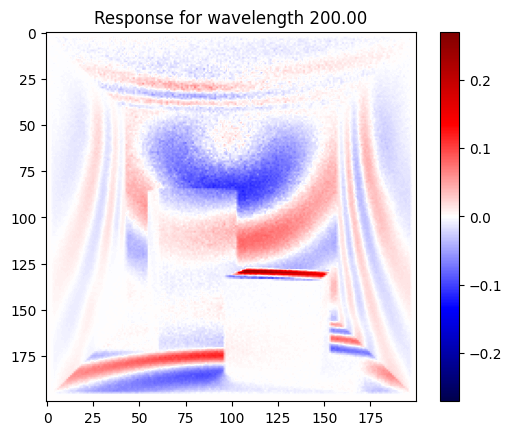

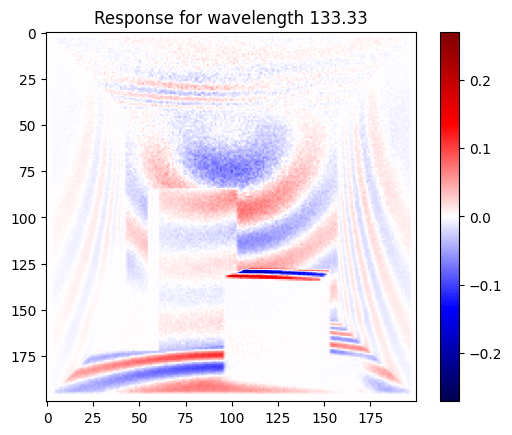

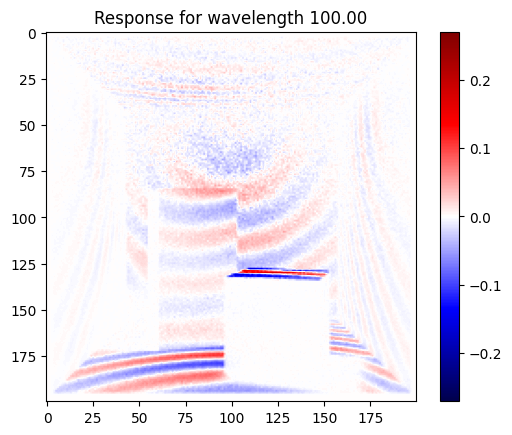

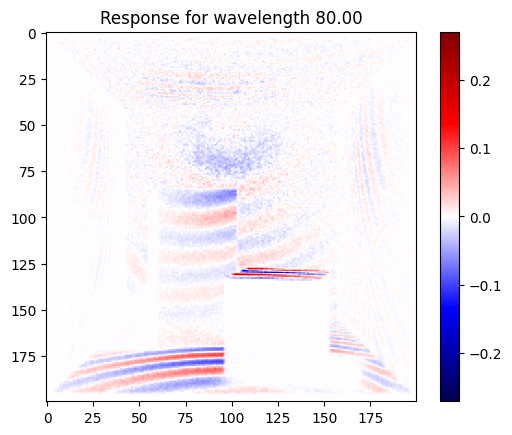

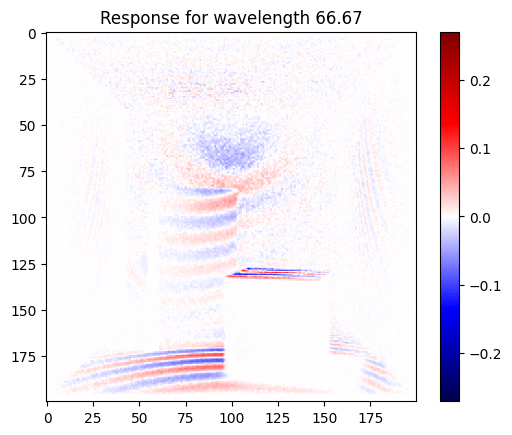

In [7]:
import matplotlib.pyplot as plt
data_freqs = np.array(data_freqs)
max_val = max(np.max(data_freqs), -np.min(data_freqs))

for i in range(0, data_freqs.shape[-2], 10):
    img = np.zeros(data_freqs.shape[:2], dtype=np.complex64)
    img = data_freqs[..., i, 0] + data_freqs[..., i, 1] * 1j
    plt.imshow(np.real(img), cmap='seismic', vmin=-max_val, vmax=max_val)
    plt.colorbar()
    plt.title(f'Response for wavelength {(1/freq_list[i]):.2f}')
    plt.show()